In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from model import PIC
import cv2
from utils import read_config
import dataset
import os

# Prepare data

In [3]:
cfg = read_config('configs/base_config.yaml')

In [4]:
if cfg.DATASET == 'ImageNet_noise_reduction':
    train_dataset = dataset.ImageNet_noise_reduction(cfg)
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=8)

    val_dataset = dataset.ImageNet_noise_reduction(cfg, 'val')
    val_dataloader = DataLoader(dataset=val_dataset, batch_size=1, shuffle=True, num_workers=8)
    
print('Train dataset length: ', len(train_dataset))
print('Val dataset length: ', len(val_dataset))

Train dataset length:  7800
Val dataset length:  1300


# Prepare net

In [5]:
from model import Model
net = Model(cfg)
print('Number of parameters in net = ', net.get_num_parameters())
net.to(torch.device(net.cfg.DEVICE))

Number of parameters in net =  1763


Model(
  (conv_inp): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_out): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

# Train

In [6]:
from train import train_val_loop

In [7]:
train_val_loop(net, train_dataloader)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: p-k-babkin (p-k-babkin-rsm). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/petr/.netrc


Training epoch [1/2] ...


100%|██████████| 1950/1950 [00:09<00:00, 208.04it/s]


Epoch [1/2] training finshed, loss =  0.0801374539732933
Validating epoch [1/2] ...


100%|██████████| 1950/1950 [00:19<00:00, 97.61it/s] 


Epoch [1/2] validation finshed.
Training epoch [2/2] ...


100%|██████████| 1950/1950 [00:08<00:00, 219.96it/s]


Epoch [2/2] training finshed, loss =  0.08682741224765778
Validating epoch [2/2] ...


100%|██████████| 1950/1950 [00:19<00:00, 97.91it/s] 


Epoch [2/2] validation finshed.


Train/MSE Block 0,█▆▂▅▃▃▄▃▃▃▃▃▃▂▂▁▃▃▁▃▃▄▃▁▃▃▃▂▄▁▂▃▃▂▁▃▃▃▄▂
Train/Total Loss,█▆▂▅▃▃▄▃▃▃▃▃▃▂▂▁▃▃▁▃▃▄▃▁▃▃▃▂▄▁▂▃▃▂▁▃▃▃▄▂
Val/ImMSE Block 0,█▅▅▇▆▅▄▅▂▅▇▁▅▄▇▅▄▅▄▅▇▅▅▅▆▆▆▄▅▆▆▅▅▆▅▆▅▆▇▅
Val/PSNR Block 0,▁▃▃▁▂▃▄▃▆▃▂█▃▄▁▃▄▃▄▃▁▃▃▃▂▃▂▄▃▂▃▃▃▂▃▂▃▃▁▃
Val/SSIM Block 0,▅▅█▇▃▆▃▄▃▄▆▁▃▃▄▆▃▃▅▄▅▄▅▁▇▂▄▅▆▅▇▇▆▅▃▅▃▅▅▃
train step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Train/MSE Block 0,0.08683
Train/Total Loss,0.08683
Val/ImMSE Block 0,83.26927
Val/PSNR Block 0,39.14292


# Look at results

In [8]:
from utils import reconstruct_im
import matplotlib.pyplot as plt

In [9]:
sample = train_dataset[0]
test_inp = {
    'im_orig' : torch.tensor(sample['im_orig']).to(torch.float).unsqueeze(0),
    'im_noisy' : torch.tensor(sample['im_noisy']).to(torch.float).unsqueeze(0),
}

net.eval()
net.cpu()
res = net(test_inp)

Text(0.5, 1.0, 'Pred')

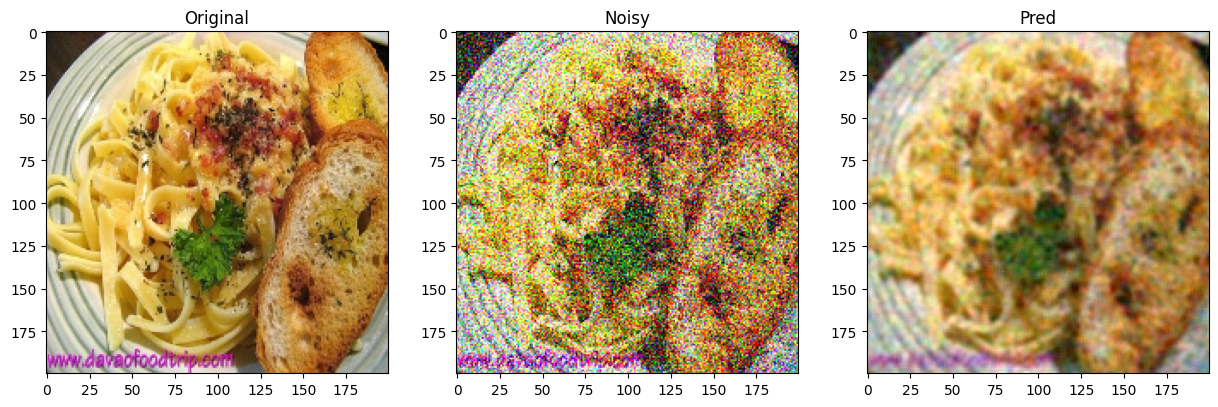

In [10]:
reconstructed_im_orig = reconstruct_im(res['im_orig'][0], cfg)
reconstructed_im_noisy = reconstruct_im(res['im_noisy'][0], cfg)
reconstructed_im_pred = reconstruct_im(res['outputs'][-1][0], cfg)

reconstructed_im_orig = cv2.cvtColor(reconstructed_im_orig, cv2.COLOR_BGR2RGB)
reconstructed_im_noisy = cv2.cvtColor(reconstructed_im_noisy, cv2.COLOR_BGR2RGB)
reconstructed_im_pred = cv2.cvtColor(reconstructed_im_pred, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Рисуем первую картинку
axes[0].imshow(reconstructed_im_orig, cmap='viridis')
axes[0].set_title('Original')

# Рисуем вторую картинку
axes[1].imshow(reconstructed_im_noisy, cmap='viridis')
axes[1].set_title('Noisy')

# Рисуем третью картинку
axes[2].imshow(reconstructed_im_pred, cmap='viridis')
axes[2].set_title('Pred')

In [11]:
import metrics as m
metrics_list = m.create_metrcs_list(cfg)

m.get_metrics_dict(metrics_list, res)

{'ImMSE Block 0': 89.4082,
 'PSNR Block 0': 38.9521478913431,
 'SSIM Block 0': 0.5944163838883034}

# Wiener filter

Text(0.5, 1.0, 'Pred')

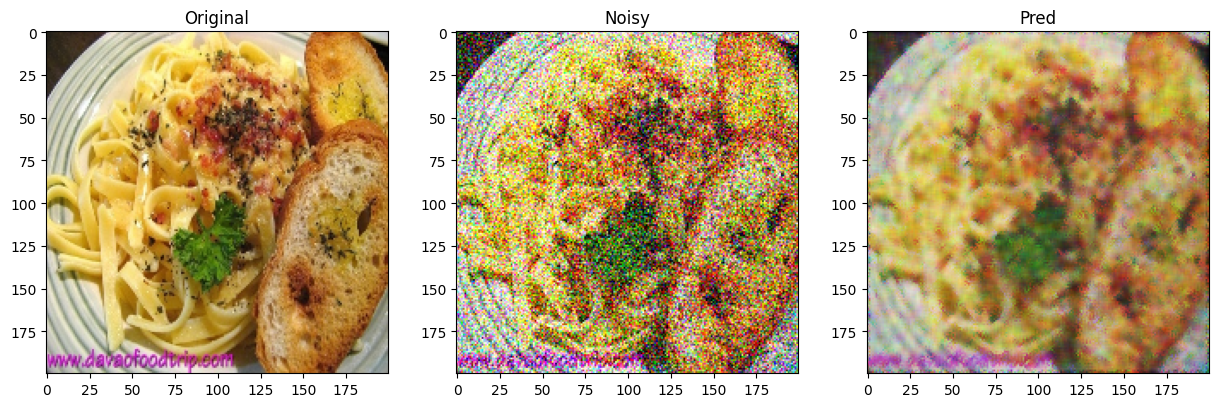

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import wiener
from skimage import io, color

image = reconstructed_im_noisy / 255

filtered_image = np.zeros_like(image)
for i in range(3):
    filtered_color = wiener(image[:, :, i], (5, 5))
    
    filtered_image[:, :, i] = filtered_color

im_filitered_reconstructed = (filtered_image * 255).astype(np.int32)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Рисуем первую картинку
axes[0].imshow(reconstructed_im_orig, cmap='viridis')
axes[0].set_title('Original')

# Рисуем вторую картинку
axes[1].imshow(reconstructed_im_noisy, cmap='viridis')
axes[1].set_title('Noisy')

# Рисуем третью картинку
axes[2].imshow(im_filitered_reconstructed, cmap='viridis')
axes[2].set_title('Pred')

In [13]:
import metrics as m

metrcs_list = m.create_metrcs_list(cfg)

metrics_dict = {}


for metric in metrcs_list:
    metrics_dict[f'Wiener filter, {metric.name}' ] = metric.calculate(im_filitered_reconstructed, reconstructed_im_orig)

metrics_dict

{'Wiener filter, ImMSE': 751.783,
 'Wiener filter, PSNR': 34.76635637456725,
 'Wiener filter, SSIM': 0.48397620023498805}